In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


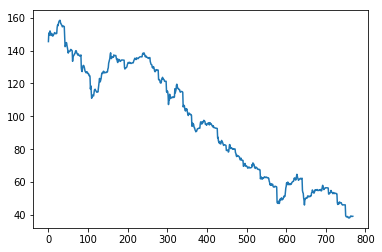

In [2]:
# 1st column of csv file is "date" which we don't need. And 3 footer lines can also be skipped.
dataset = pd.read_csv('iron_price.csv', usecols=[1], engine='python', skipfooter=3)

plt.plot(dataset)
plt.show()

In [3]:
# fix random seed for reproducibility
seed = np.random.seed(11)

In [4]:
# normalize the dataset
data_range = (-1, 1)
scaler = MinMaxScaler(feature_range=data_range)        
scaler.fit(dataset)
# scaler can also de-normalize the dataset by scaler.inverse_transform(), useful for actual prediction
dataset_scaled = scaler.transform(dataset)

In [5]:
print(dataset_scaled.shape)
print("\n",dataset_scaled[0:10])

(769, 1)

 [[0.78396344]
 [0.87120897]
 [0.86289988]
 [0.85043623]
 [0.89198172]
 [0.87752389]
 [0.85974242]
 [0.84628168]
 [0.86605733]
 [0.86157042]]


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    i_range = len(data) - look_back - 1
    #print(i_range)
    for i in range(0, i_range):
        dataX.append(data[i:(i+look_back)])    # index can move down to len(dataset)-1
        dataY.append(data[i + look_back])      # Y is the item that skips look_back number of items
    
    return np.array(dataX), np.array(dataY)

In [7]:
# accounting 120 columns for lag as feature for the next prediction, I have tried 10 and 40 as well but 120 produces the changes gradually and accurately (not very significantly accurate)
look_back = 120
dataX, dataY = create_dataset(dataset_scaled, look_back=look_back)

In [8]:
print("X shape:", dataX.shape)
print("Y shape:", dataY.shape)
   
print("Xt-119    Xt-118   Xt-117   ...    Xt        Y")
print("---------------------------------------------")

for i in range(len(dataX)): 
    print('%.2f  \t %.2f  \t  %.2f    ...   %.2f    %.2f' % (dataX[i][0][0], dataX[i][1][0], dataX[i][2][0], dataX[i][59][0], dataY[i][0]))


X shape: (648, 120, 1)
Y shape: (648, 1)
Xt-119    Xt-118   Xt-117   ...    Xt        Y
---------------------------------------------
0.78  	 0.87  	  0.86    ...   0.69    0.29
0.87  	 0.86  	  0.85    ...   0.69    0.28
0.86  	 0.85  	  0.89    ...   0.58    0.27
0.85  	 0.89  	  0.88    ...   0.63    0.27
0.89  	 0.88  	  0.86    ...   0.64    0.28
0.88  	 0.86  	  0.85    ...   0.65    0.27
0.86  	 0.85  	  0.87    ...   0.65    0.31
0.85  	 0.87  	  0.86    ...   0.66    0.34
0.87  	 0.86  	  0.84    ...   0.66    0.37
0.86  	 0.84  	  0.84    ...   0.68    0.41
0.84  	 0.84  	  0.85    ...   0.69    0.37
0.84  	 0.85  	  0.85    ...   0.69    0.38
0.85  	 0.85  	  0.86    ...   0.68    0.39
0.85  	 0.86  	  0.87    ...   0.66    0.41
0.86  	 0.87  	  0.88    ...   0.66    0.44
0.87  	 0.88  	  0.87    ...   0.65    0.47
0.88  	 0.87  	  0.87    ...   0.66    0.47
0.87  	 0.87  	  0.86    ...   0.66    0.46
0.87  	 0.86  	  0.87    ...   0.65    0.48
0.86  	 0.87  	  0.87    ...  

In [9]:
# Reshape to (samples, timestep, features)
dataX = np.reshape(dataX, (dataX.shape[0], dataX.shape[1], 1))

print("X shape:", dataX.shape)

X shape: (648, 120, 1)


In [12]:
# splitting the date into train and test value
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
dataX, dataY = shuffle(dataX, dataY, random_state=4)

trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=0.25, random_state=11)

In [15]:
# create and fit the LSTM network
from keras.layers import Dropout
from keras.layers import Flatten

batch_size = 32
timesteps = trainX.shape[1]
input_dim = trainX.shape[2]

model = Sequential()
model.add(LSTM(30, input_shape=(timesteps, input_dim)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mean_squared_error'])

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [17]:
# calculation og MSE and validation MSE parallely
training = model.fit(trainX, trainY, epochs=50, batch_size=batch_size, validation_data = (testX, testY), verbose=2)  

Train on 486 samples, validate on 162 samples
Epoch 1/50
 - 2s - loss: 0.2638 - mean_squared_error: 0.2638 - val_loss: 0.1437 - val_mean_squared_error: 0.1437
Epoch 2/50
 - 2s - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 3/50
 - 2s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 4/50
 - 2s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 5/50
 - 2s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 6/50
 - 2s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 7/50
 - 2s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 8/50
 - 2s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 9/50
 - 1s - loss: 0.0025 - mean_squared_err

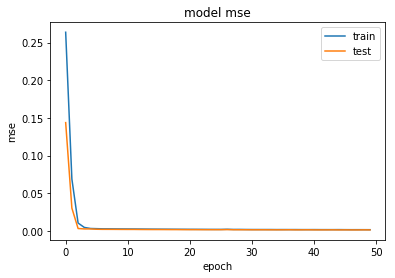

In [20]:
# visualise training history
plt.plot(training.history['mean_squared_error'])
plt.plot(training.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="upper right")
plt.show() # Seems like epochs are not necessary there is a good convergence in early stage itself

In [21]:
# make predictions
trainPredict = model.predict(trainX, batch_size)
testPredict = model.predict(testX, batch_size)   

In [22]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.03 RMSE


In [23]:
# scale back rmse - optional - just to see rmse on original values of time series
trainScore_unscaled = scaler.inverse_transform(trainScore)
print('Train Score: %.2f RMSE' % (trainScore_unscaled))
testScore_unscaled = scaler.inverse_transform(testScore)
print('Train Score: %.2f RMSE' % (testScore_unscaled))

Train Score: 100.65 RMSE
Train Score: 100.39 RMSE


In [24]:
# now i have to generate the sequence of prediction for the period of 1st January till 31st March
def generate_seq(model, seq_length, seed_series, future_days):
    """
    model        :  keras model
    seq_length   :  previous timestamps neded to forecast next timestamp
    seed_series  :  initial values to start prediction, ex: [1,2,3,4]
    future_days  :  number of days to forecast timestamps for
    """
    # scale seed series
    seed_series = np.reshape(seed_series, (-1, 1))
    seed_series_scaled = scaler.transform(seed_series)
    
    result = list()
    in_series = list(seed_series_scaled)
    # extrapolate time series
    for _ in range(future_days):
        in_series = in_series[-seq_length:]
        # predict next time stamp
        next_timestamp = model.predict(np.reshape(in_series, (1, timesteps, input_dim)), verbose=0)
        # append to input
        in_series.append(next_timestamp)# += ' ' + float()
        result.append(next_timestamp)
        result = [float(res) for res in result]
        
    # unscale result
    result_unscaled = np.array(result)
    result_unscaled = np.reshape(result_unscaled, (-1, 1))
    result_unscaled = scaler.inverse_transform(result_unscaled)
    
    return result_unscaled

In [26]:
# here i am inputting the data for last 60 days prices for the prediction of next 90 days
input_series = [50.08, 50.5, 51.5, 51.5, 51, 51.25, 51.13, 51.2, 51.09, 51.59, 51.58, 51.57, 53.44, 53.67, 55.17, 54.74, 53.75, 53.58, 53.21, 53.65, 54.94, 55.25, 54.8, 55.28, 55.16, 55.17, 55.46, 54.88, 54.88, 54.8, 54.96, 55.08, 55.28, 55, 54.75, 55.44, 55.44, 54.62, 55.28, 56.92, 58, 57.06, 56.25, 55.41, 55.85, 56.16, 56.25, 56.54, 56.5, 56.5, 56.5, 56.5, 56.43, 56.43, 56.35, 52.7, 52.65, 53.08, 53.5, 53.42, 53.67, 54.87, 54.25, 53.63, 53.53, 53.5, 52.88, 53.17, 53.62, 53.19, 53, 53, 53.21, 53.14, 53.05, 52.83, 52.74, 47.43, 46.33, 47.27, 46.46, 46.79, 47.81, 47.5, 47.6, 47.38, 47.38, 47.38, 46.59, 46.26, 46, 46.12, 46.12, 46.17, 46.11, 46.17, 46.09, 46.1, 39.63, 39.03, 38.78, 38.78, 39.04, 38.92, 38.73, 38.15, 38.28, 38.45, 38.2, 38.55, 38.8, 39.32, 39.28, 39.03, 39.03, 39.12, 39.15, 39.31, 39.31, 39.58]
Predicted_Price = generate_seq(model, timesteps, input_series, 90) # 91 days in between 2nd January to 31st March

In [29]:
Predicted_Price

array([[39.10398582],
       [39.16102526],
       [39.18571617],
       [39.18847435],
       [39.17690362],
       [39.1556703 ],
       [39.12772266],
       [39.09496524],
       [39.05872872],
       [39.01991694],
       [38.97922213],
       [38.93713568],
       [38.89405571],
       [38.85031579],
       [38.80611677],
       [38.76173124],
       [38.71726321],
       [38.67288486],
       [38.6286966 ],
       [38.58480603],
       [38.54128131],
       [38.49818341],
       [38.45555896],
       [38.41345099],
       [38.37190613],
       [38.33092439],
       [38.29055597],
       [38.25077219],
       [38.2116376 ],
       [38.17313069],
       [38.13525862],
       [38.09801423],
       [38.0614011 ],
       [38.02544075],
       [37.99009732],
       [37.95539232],
       [37.92129706],
       [37.88781154],
       [37.85492858],
       [37.82266972],
       [37.79098473],
       [37.75988795],
       [37.72936506],
       [37.69940169],
       [37.66999784],
       [37

In [30]:
# storing the results (Predicted_Price) in dataframe
df1 = pd.DataFrame(data=Predicted_Price, columns  = ["Pred_Price"])

In [31]:
df1.head()

,Pred_Price
0,39.103986
1,39.161025
2,39.185716
3,39.188474
4,39.176904


In [32]:
# genearating Data Sequence from 2nd January till 1st April (91 days)
Date  = pd.date_range(start='1/2/2016', end='3/31/2016')

In [34]:
# storing it to a dataframe
df2 = pd.DataFrame(data=Date, columns = ['Dates'])

In [35]:
df2.head()

,Dates
0,2016-01-02
1,2016-01-03
2,2016-01-04
3,2016-01-05
4,2016-01-06


In [36]:
# final dataframe combination of date and predicted price
Final_Prediction = pd.concat(objs = [df2,df1], axis = 1)

In [37]:
Final_Prediction.head(15)

,Dates,Pred_Price
0,2016-01-02,39.103986
1,2016-01-03,39.161025
2,2016-01-04,39.185716
3,2016-01-05,39.188474
4,2016-01-06,39.176904
5,2016-01-07,39.155670
6,2016-01-08,39.127723
7,2016-01-09,39.094965
8,2016-01-10,39.058729
9,2016-01-11,39.019917


In [38]:
# wrting it back to csv
Final_Prediction.to_csv("iron_forecasted_price.csv", sep =',',index = False)